In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from functools import partial, reduce

In [3]:
from given_eda import get_train_dfs , split_data_by_city , add_4_rolling_means
from feature_eng import add_4_rolling_means,add_8_rolling_means,add_previous_max,add_dengue_lags

In [5]:
#to be deleted before commit
path_to_features = "/Users/mussayababbasshamsi/Desktop/Kiran/dengAI-competition/data2/dengue_features_train.csv"
path_to_labels = "/Users/mussayababbasshamsi/Desktop/Kiran/dengAI-competition/data2/dengue_labels_train.csv"

def get_train_dfs():
    train_df = preprocess_data(path_to_features, labels_path = path_to_labels)
    return train_df


def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    #now including more than the original 4. remember: baselines were created using original 4
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
                 'reanalysis_relative_humidity_percent',
                 'reanalysis_min_air_temp_k',
                 'reanalysis_max_air_temp_k'
                 ]
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    return df

def split_data_by_city(df):
    sj = df.loc['sj']
    iq = df.loc['iq']

    return sj , iq

In [4]:
#to be deleted before commit
def add_4_rolling_means(df):

    df2 = df.rolling(window=4).mean()
    df2 = df2.rename(columns={x: x + '_4' for x in df2.columns})
    #df_all = pd.merge(df,df2, how='left',on=['year','weekofyear'])

    return df2

def add_8_rolling_means(df):

    df2 = df.rolling(window=8).mean()
    df2 = df2.rename(columns={x: x + '_8' for x in df2.columns})
    #df_all = pd.merge(df,df2, how='left',on=['year','weekofyear'])

    return df2


def  add_previous_max(df):
    df2 = df.rolling(window=4).max()
    df2 = df2.rename(columns={x: x + '_max' for x in df2.columns})
    #df_all = pd.merge(df,df2, how='left',on=['year','weekofyear'])

    return df2

def add_dengue_lags(df):

    df['prev_avg_cases_4'] = df['total_cases'].rolling(window=4).mean()
    df['prev_avg_cases_8'] = df['total_cases'].rolling(window=8).mean()

    return df

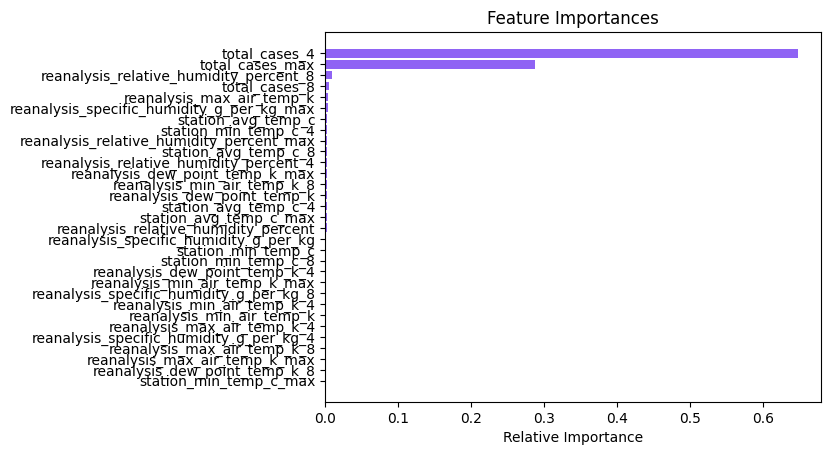

In [20]:
all_data = get_train_dfs()

sj , iq = split_data_by_city(all_data)

sj_labels = sj.total_cases
sj_4 = add_4_rolling_means(sj)
sj_8 = add_8_rolling_means(sj)
sj_max = add_previous_max(sj)

dfs = [sj, sj_4, sj_8,sj_max]
merge = partial(pd.merge, on=['year','weekofyear'], how='outer')
lagged_sj = reduce(merge, dfs)
lagged_sj = lagged_sj.loc[:, lagged_sj.columns != "total_cases"]

lagged_sj = lagged_sj.fillna(method='bfill')

sjX_train, sjX_test, sjy_train, sjy_test = train_test_split(
        lagged_sj, sj_labels, test_size=0.30,shuffle=False
    )

regressor = RandomForestRegressor()
regressor.fit(sjX_train, sjy_train)

features = lagged_sj.columns
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Analysis:

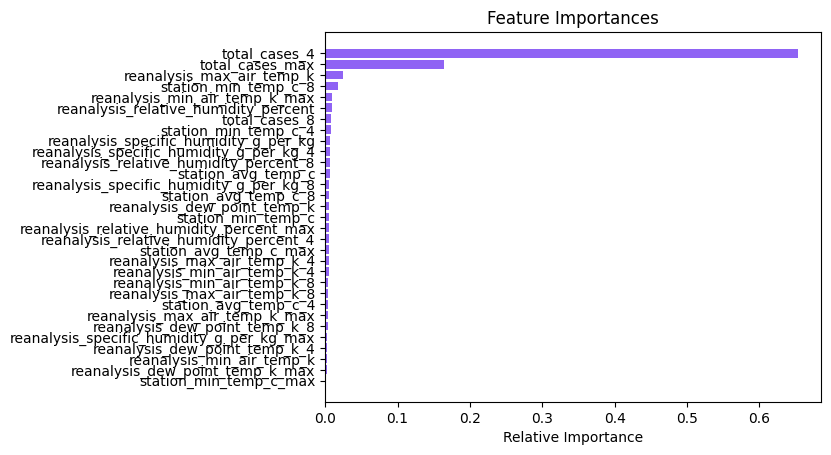

In [21]:
iq_labels = iq.total_cases
iq_4 = add_4_rolling_means(iq)
iq_8 = add_8_rolling_means(iq)
iq_max = add_previous_max(iq)

dfs = [iq, iq_4, iq_8,iq_max]
merge = partial(pd.merge, on=['year','weekofyear'], how='outer')
lagged_iq = reduce(merge, dfs)
lagged_iq = lagged_iq.loc[:, lagged_iq.columns != "total_cases"]

lagged_iq = lagged_iq.fillna(method='bfill')

iqX_train, iqX_test, iqy_train, iqy_test = train_test_split(
        lagged_iq, iq_labels, test_size=0.30, shuffle=False
    )

regressor = RandomForestRegressor()
regressor.fit(iqX_train, iqy_train)

features = lagged_iq.columns
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Analysis:


Keeping only the most important variables:

In [27]:
sjX_train = sjX_train[['total_cases_4','total_cases_8','total_cases_max','station_avg_temp_c','station_min_temp_c_8','reanalysis_relative_humidity_percent','reanalysis_relative_humidity_percent_4','reanalysis_relative_humidity_percent_8']]
sjX_test = sjX_test[['total_cases_4','total_cases_8','total_cases_max','station_avg_temp_c','station_min_temp_c_8','reanalysis_relative_humidity_percent','reanalysis_relative_humidity_percent_4','reanalysis_relative_humidity_percent_8']]

From the baseline models, SVR gave the best result with a MAE of 20.82, RMSE of 45.19 and an R^2 of -0.042 for San Juan

In [30]:
model = SVR()
params = {
            "kernel": ("linear", "rbf", "poly"),
            "C": [1.5, 10],
            "gamma": [1e-7, 1e-4],
            "epsilon": [0.1, 0.2, 0.5, 0.3],
        }
grid_model_sj = GridSearchCV(estimator=model, param_grid=params, cv=2)
grid_model_sj.fit(sjX_train, sjy_train)
sj_predictions = grid_model_sj.predict(sjX_test)
rmse = np.sqrt(mean_squared_error(sjy_test, sj_predictions))
mae = mean_absolute_error(sjy_test, sj_predictions)
r2 = r2_score(sjy_test, sj_predictions)

print(f"RMSE: {rmse} , MAE: {mae}, R^2: {r2}")

RMSE: 7.58986657663778 , MAE: 4.298416092382415, R^2: 0.9185655557963028


In [ ]:
grid_model_sj.best

We see a big improvemnet with the addition of feature engineering to the MAE metric. 

In [ ]:
iqX_train = iqX_train[['total_cases_4','total_cases_8','total_cases_max','station_avg_temp_c','station_min_temp_c_8','reanalysis_relative_humidity_percent','reanalysis_relative_humidity_percent_4','reanalysis_relative_humidity_percent_8']]
iqX_test = iqX_test[['total_cases_4','total_cases_8','total_cases_max','station_avg_temp_c','station_min_temp_c_8','reanalysis_relative_humidity_percent','reanalysis_relative_humidity_percent_4','reanalysis_relative_humidity_percent_8']]

In [31]:
model = SVR()
params = {
            "kernel": ("linear", "rbf", "poly"),
            "C": [1.5, 10],
            "gamma": [1e-7, 1e-4],
            "epsilon": [0.1, 0.2, 0.5, 0.3],
        }
grid_model_iq = GridSearchCV(estimator=model, param_grid=params, cv=2)
grid_model_iq.fit(iqX_train, iqy_train)
iq_predictions = grid_model_iq.predict(iqX_test)
rmse = np.sqrt(mean_squared_error(iqy_test, iq_predictions))
mae = mean_absolute_error(iqy_test, iq_predictions)
r2 = r2_score(iqy_test, iq_predictions)

print(f"RMSE: {rmse} , MAE: {mae}, R^2: {r2}")

RMSE: 5.66851875356297 , MAE: 3.5033226733114238, R^2: 0.77158926159433
